### Gongwei's RNASeq Data Analysis

#### Step 1:
Create working directory in O2 server. <br>
``` mkdir /n/scratch2/ajit ```
#### Step 2:
Clone BcBio pipeline into the directory. <br>
This clones the data into a new directory named *rnaseq* <br>
``` git clone https://github.com/datarail/rnaseq.git  ```
``` cd rnaseq   ```
#### Step 3:
Create directory to download fastq files and copy the data into it. <br>
``` mkdir /n/scratch2/ajit/rnaseq/allsamples  ``` <br>
``` scp -r "/mnt/c/Users/ajn16/Downloads/gw/" ajn16@transfer.rc.hms.harvard.edu:/n/scratch2/ajit/rnaseq/allsamples/ ```<br>
``` cd allsamples   ```
#### Step 4:
Create a sample description file and copy it into the *allsamples* folder. This will serve as the template for merging the same samples from different lanes into one *fastq* file. <br>
```scp -r "/mnt/c/Users/ajn16/Dropbox (Partners HealthCare)/Jupyter Notebooks/runs/gw_rnaseq_metadata/merge_config.csv" ajn16@transfer.rc.hms.harvard.edu:/n/scratch2/ajit/rnaseq/allsamples/ ```<br>
<br>
```scp -r "/mnt/c/Users/ajn16/Dropbox (Partners HealthCare)/Jupyter Notebooks/runs/gw_rnaseq_metadata/doMerge.sh" ajn16@transfer.rc.hms.harvard.edu:/n/scratch2/ajit/rnaseq/allsamples/``` <br>
<br>
In-order to merge the files we also need a *doMerge.sh* script. Copy this also into the same folder as above. <br>
**Sample description file**: https://github.com/ajitjohnson/Jupyter-Notebooks/blob/master/runs/gw_rnaseq_metadata/merge_config.csv <br>
**doMerge.sh file**: https://github.com/ajitjohnson/Jupyter-Notebooks/blob/master/runs/gw_rnaseq_metadata/doMerge.sh <br>
#### Step 5:
Run doMerge.sh to combine the four lanes into a single fastq file (for each sample) <br>
``` ./doMerge.sh  ```
#### Step 6:
Move the merged files to the *rnaseq* directory <br>
``` mv -v /n/scratch2/ajit/rnaseq/allsamples/merged /n/scratch2/ajit/rnaseq/   ```
<br>
Move the **merge_config-merged.csv** file to *rnaseq* directory and rename it **alignment.csv**<br>
``` mv /n/scratch2/ajit/rnaseq/allsamples/merge_config-merged.csv /n/scratch2/ajit/rnaseq/  ```<br>
```cd .. ``` <br>
```mv merge_config-merged.csv alignment.csv ```
#### Step 7:
Create a directory for downloading the reference genome <br>
``` mkdir reference ```<br>
``` cd reference/ ``` <br>
Download reference genome <br>
```
wget ftp://ftp.ensembl.org/pub/release-95/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
wget ftp://ftp.ensembl.org/pub/release-95/gtf/homo_sapiens/Homo_sapiens.GRCh38.95.gtf.gz
wget ftp://ftp.ensembl.org/pub/release-95/fasta/homo_sapiens/ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz
```
#### Step 8:
UnZip all files 
```gunzip *.gz```
#### Step 9:
Concatenate cdna and ncrna -> Homo_sapiens.GRCh38.95.fa <br>
```cat Homo_sapiens.GRCh38.cdna.all.fa Homo_sapiens.GRCh38.ncrna.fa > ./Homo_sapiens.GRCh38.95.fa ```
#### Step 10:
Edit **alignment.csv** if necessary: Remove unwanted commas ,'s <br>
``` vim /n/scratch2/ajit/rnaseq/alignment.csv```
#### Step 11:
Edit **yaml_O2.yaml** if necessary <br>
``` vim /n/scratch2/ajit/rnaseq/yaml_O2.yaml```
Example yamal file: https://github.com/ajitjohnson/Jupyter-Notebooks/blob/master/runs/gw_rnaseq_metadata/yaml_O2.yaml <br>
#### Step 12:
Initiate the bcbio workspace <br>
``` bcbio_nextgen.py -w template yaml_O2.yaml alignment.csv merged/```
#### Step 13:
Descend into the work subdirectory of your project <br>
``` cd /n/scratch2/ajit/rnaseq/alignment/work ```
#### Step 14:
Edit *submit_bcbio.sh* if necessary <br>
```vim /n/scratch2/ajit/rnaseq/submit_bcbio.sh```<br>
and add <br>
```
#SBATCH --mail-type=ALL
#SBATCH --mail-user=ajit_nirmal@hms.harvard.edu
change `../config/sample_description.yaml` to `../config/alignment.yaml`
```
From the work directory, submit the job to O2 using the following command: <br>
``` sbatch ../../submit_bcbio.sh ```
#### Step 15:
Check job progress <br>
```sacct```
#### Step 16:
The counts file will be located in ../final/2017-10-19_sample_description/combined.counts, but depending on the current date and the contents of your sample_description.csv, the actual path may vary. <br>
```cd /n/scratch2/ajit/rnaseq/alignment/finals/2019-01-23_alignment/```
#### Step 17:
Download combined.counts to local drive from terminal.  <br>
```scp ajn16@transfer.rc.hms.harvard.edu:/n/scratch2/ajit/rnaseq/alignment/finals/2019-01-23_alignment/combined.counts /Users/aj/Downloads/temp```
#### Step 18:
alignment-independent quantification. To get a count table from salmon you need quant.sf files that are scattered across individual-sample directories. Running the following on the command line will pull all the .sf files together and output a counts table and a TPM (transcripts-per-million) table:  <br>
```Rscript merge-sf.R```
#### Step 19:
Download combined.counts to local drive from terminal.  <br>
```scp ajn16@transfer.rc.hms.harvard.edu:/n/scratch2/ajit/rnaseq/alignment/finals/combined.sf /Users/aj/Downloads/temp```

----

### Analysis

#### Import Library


In [28]:
# Project specific libraries
library(limma)
library(DESeq2)
library(reshape2)
library(ggplot2)
library(cowplot)
library("pheatmap")
library("RColorBrewer")
library(biomaRt)

In [3]:
# Import Lib for exixting scripts
library(devtools)
library(roxygen2)

#### Working directory

In [4]:
# MAC
#setwd ("/Users/aj/Dropbox (Partners HealthCare)/Data/gongwei")
# HMS
setwd ("C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/gongwei")

#### Import data

In [16]:
data <- read.csv("combined.counts", header=T, sep="", row.names = 1)
pdata <- read.table("pdata.txt", header=T, sep="\t",row.names = 1)
dim(data)

[1] 58735    10

In [17]:
head(data)

,A,B,C,D,E,F,G,H,I,J
ENSG00000223972,0,1,0,0,0,0,0,0,1,0
ENSG00000227232,4,8,10,11,5,6,5,5,3,7
ENSG00000278267,1,0,2,2,0,0,0,1,1,2
ENSG00000243485,0,0,0,0,0,0,0,0,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0


#### Pre-processing

In [18]:
# Remove transcripts that are not expressed in 2 or more samples
data <- data[apply(data[2:ncol(data)] == 0, 1, sum) <= 2, ]
dim (data)

[1] 18572    10

#### Map ENSEMBL names to Gene Symbols

In [67]:
# Download ENSEMBL-GENE mapping
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
genes <- getBM(attributes=c('ensembl_gene_id','hgnc_symbol'), mart = ensembl)
# Merge data
data_m = merge(data, genes, by.x="row.names", by.y= "ensembl_gene_id")
head(data_m)

Row.names,A,B,C,D,E,F,G,H,I,J,hgnc_symbol
ENSG00000000003,4,0,2,0,4,2,21,16,8,4,TSPAN6
ENSG00000000419,903,1021,706,657,961,410,510,445,740,673,DPM1
ENSG00000000457,433,464,489,504,453,222,477,588,638,583,SCYL3
ENSG00000000460,600,690,618,563,704,302,372,203,613,687,C1orf112
ENSG00000000938,873,1136,1404,2327,1347,760,1287,2620,2418,1596,FGR
ENSG00000000971,9,8,20,31,0,0,13,30,21,2,CFH


#### Prepare data for collating multiple transcripts into one gene

In [68]:
data_merged <- data_m[,-1]
names(data_merged)[names(data_merged) == 'hgnc_symbol'] <- 'gene'
head(data_merged)

A,B,C,D,E,F,G,H,I,J,gene
4,0,2,0,4,2,21,16,8,4,TSPAN6
903,1021,706,657,961,410,510,445,740,673,DPM1
433,464,489,504,453,222,477,588,638,583,SCYL3
600,690,618,563,704,302,372,203,613,687,C1orf112
873,1136,1404,2327,1347,760,1287,2620,2418,1596,FGR
9,8,20,31,0,0,13,30,21,2,CFH


#### Merge multiple transcripts into one gene

In [69]:
# Import function
source_url("https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/r_scripts/collapse_to_one_gene.R")
# Merge
data_merged <- genesummary (data_merged)
dim(data_merged)
head(data_merged)

SHA-1 hash of file is a0c6a4622daa5b3775f335059a29d6224d9f4032


[1] 15395    10

,A,B,C,D,E,F,G,H,I,J
,897,932,2137,2708,937,504,848,1577,1078,897
A1BG-AS1,20,10,17,30,9,6,14,48,23,14
AAAS,658,842,648,604,625,363,682,579,775,792
AACS,362,394,388,439,314,156,697,756,559,548
AACSP1,1,3,0,2,1,1,5,7,5,4
AAGAB,809,842,962,863,760,333,706,684,824,812


In [19]:
pdata

,Treatment,Note,other_name
A,no_dox,TP63_kd_ctrl_rep1,shTP63-dox
B,no_dox,TP63_kd_ctrl_rep2,shTP63-dox-2
C,dox,TP63_kd_rep1,shTP63+dox-1
D,dox,TP63_kd_rep2,shTP63+dox-2
E,DMSO,DS3201b_ctrl_rep1,DS0-1
F,DMSO,DS3201b_ctrl_rep2,DS0-2
G,DS3201b,DS3201b_1uM_rep1,DS1-1
H,DS3201b,DS3201b_1uM_rep2,DS1-2
I,DS3201b,DS3201b_30nM_rep1,DS30-1
J,DS3201b,DS3201b_30nM_rep2,DS30-2


## Analysis

### Effect of knocking down *TP63*

In [72]:
# Subset the TP63 data
data_tp63 <- data_merged[,c("A","B","C","D")]
pdata_tp63 <- pdata[c("A","B","C","D"),]

In [75]:
# DESeq analaysis
dds_tp63 <- DESeqDataSetFromMatrix(countData = data_tp63, colData = pdata_tp63, design = ~ Treatment)
dds_tp63 <- DESeq(dds_tp63)
# Normalize the data by rlog method for other analysis
rld_tp63 <- rlog(dds_tp63, blind=FALSE)
# Extract the normalised data from the deseq file
#n_data <- data.frame(counts(dds, normalized=TRUE))
n_data_tp63 <- data.frame(assay(rld_tp63))
head(n_data_tp63)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


,A,B,C,D
,9.9801502,9.9162740,11.0038384,11.2441347
A1BG-AS1,4.2638691,4.0915874,4.2156466,4.3782131
AAAS,9.4140464,9.5916464,9.3777978,9.2513340
AACS,8.5705584,8.5627236,8.6268138,8.7151002
AACSP1,0.5359286,0.5674314,0.5175317,0.5520051
AAGAB,9.7213752,9.6610199,9.9043843,9.7291353


#### Vizulaize expression profile before and after normalization

SHA-1 hash of file is ea705fcd7367ec2f0f16b7660c0ae5b75421a27c
No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 917 rows containing non-finite values (stat_boxplot)."

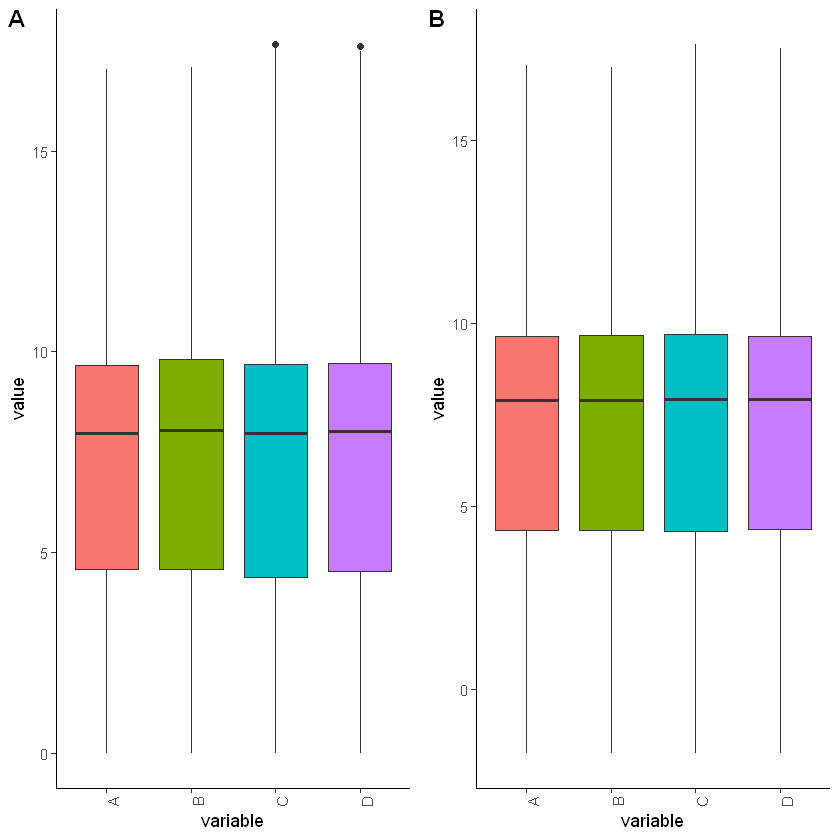

In [76]:
source_url("https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/r_scripts/plot_before_after_normalization.R")
plotba (data_tp63,n_data_tp63)

#### Plot PCA

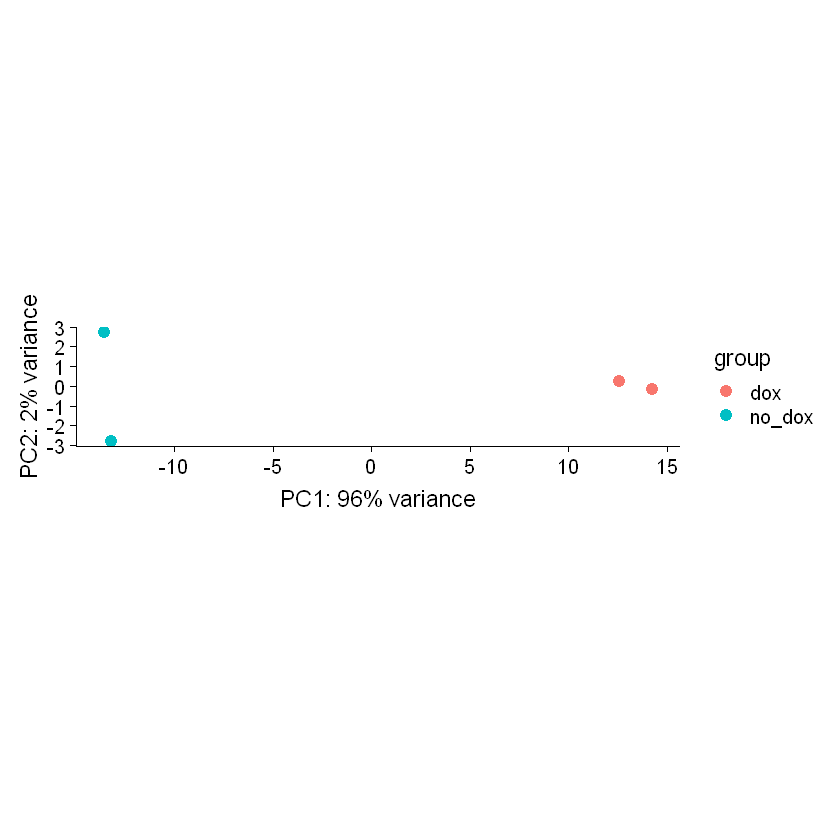

In [77]:
plotPCA(rld_tp63, intgroup="Treatment")

#### Differentially expressed genes

In [80]:
res_tp63 <- results(dds_tp63)
res_tp63 <- res[order(res_tp63$padj),]
summary(res_tp63)


out of 15395 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2751, 18%
LFC < 0 (down)     : 2655, 17%
outliers [1]       : 0, 0%
low counts [2]     : 2090, 14%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [81]:
head(res_tp63)

log2 fold change (MLE): Treatment no dox vs dox 
Wald test p-value: Treatment no dox vs dox 
DataFrame with 6 rows and 6 columns
               baseMean      log2FoldChange             lfcSE
              <numeric>           <numeric>         <numeric>
CCSER2 471.245684585046  -0.562337679913557 0.167980059542897
NXF1   1547.81716853488   0.099182072841405 0.150946856642946
ZDHHC2 762.048660736359  -0.526653546933053  0.15425241483874
ZNF318 717.039263379108  -0.515211788603358  0.14851346003258
GMPR2  635.622395700147 -0.0909532183164543 0.153911171908999
NPTXR  73.9878063756244  -0.793582073706512 0.349131730736034
                     stat               pvalue                padj
                <numeric>            <numeric>           <numeric>
CCSER2   -3.3476454374631 0.000815012106483563 0.00377435992925994
NXF1    0.657066169161859    0.511138370841935   0.661803817054491
ZDHHC2  -3.41423210446095 0.000639620609724519 0.00307076316328306
ZNF318  -3.46912521255874 0.000522156036

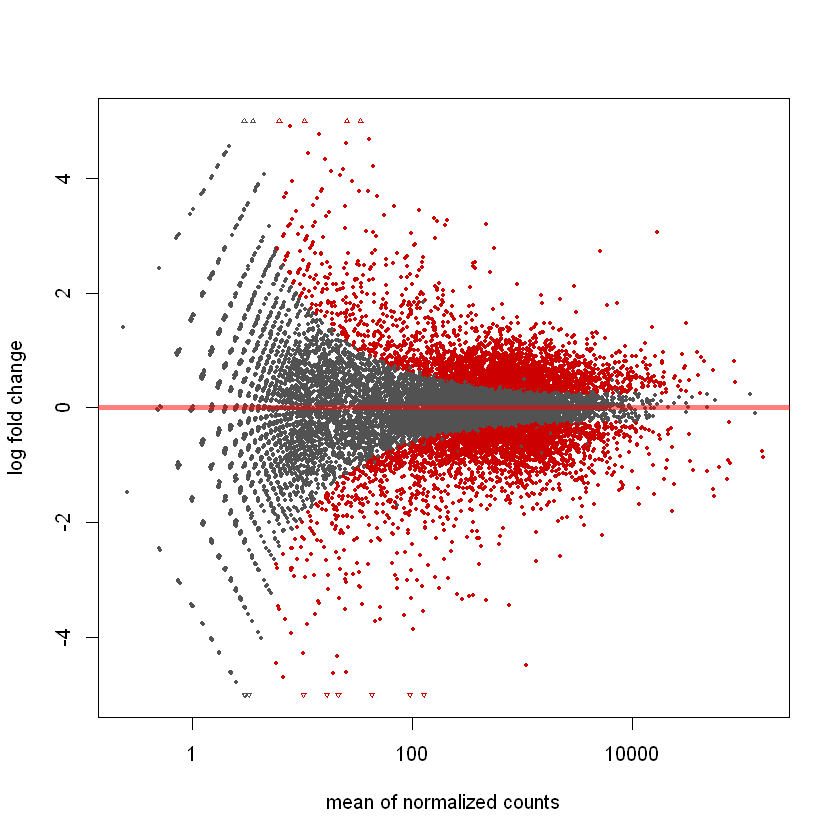

In [84]:
plotMA(res_tp63, ylim=c(-5,5))

#### Export Data

In [85]:
# Export normalized matrix
write.csv(n_data_tp63, file = "results/tp63_normalized.csv")
# Export DEG matrix
write.csv(res_tp63, file = "results/DEG_tp63.csv")

### Differential genes by treatment of the drug DS3201b

#### A. DS0 vs DS1

In [87]:
# Subset the 0v1
data_0v1 <- data_merged[,c("E","F","G","H")]
pdata_0v1 <- pdata[c("E","F","G","H"),]

In [90]:
# DESeq analaysis
dds_0v1 <- DESeqDataSetFromMatrix(countData = data_0v1, colData = pdata_0v1, design = ~ Treatment)
dds_0v1 <- DESeq(dds_0v1)
# Normalize the data by rlog method for other analysis
rld_0v1 <- rlog(dds_0v1, blind=FALSE)
# Extract the normalised data from the deseq file
n_data_0v1 <- data.frame(assay(rld_0v1))
head(n_data_0v1)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


,E,F,G,H
,9.573823,9.636052,9.671403,10.277181
A1BG-AS1,3.710670,3.805855,3.908474,4.493152
AAAS,8.965343,9.110557,9.269445,8.987177
AACS,8.118838,8.101814,9.194162,9.184370
AACSP1,1.590863,1.625856,1.726468,1.767889
AAGAB,9.207939,9.042254,9.333891,9.197699


#### Vizulaize expression profile before and after normalization

SHA-1 hash of file is ea705fcd7367ec2f0f16b7660c0ae5b75421a27c
No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 1521 rows containing non-finite values (stat_boxplot)."

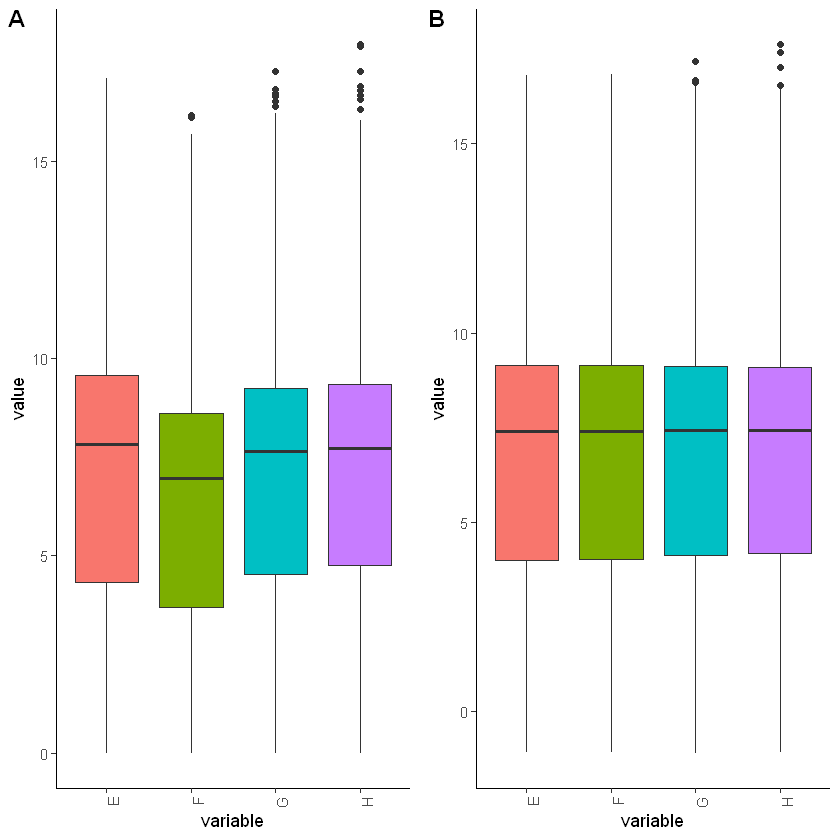

In [91]:
source_url("https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/r_scripts/plot_before_after_normalization.R")
plotba (data_0v1,n_data_0v1)

#### Plot PCA

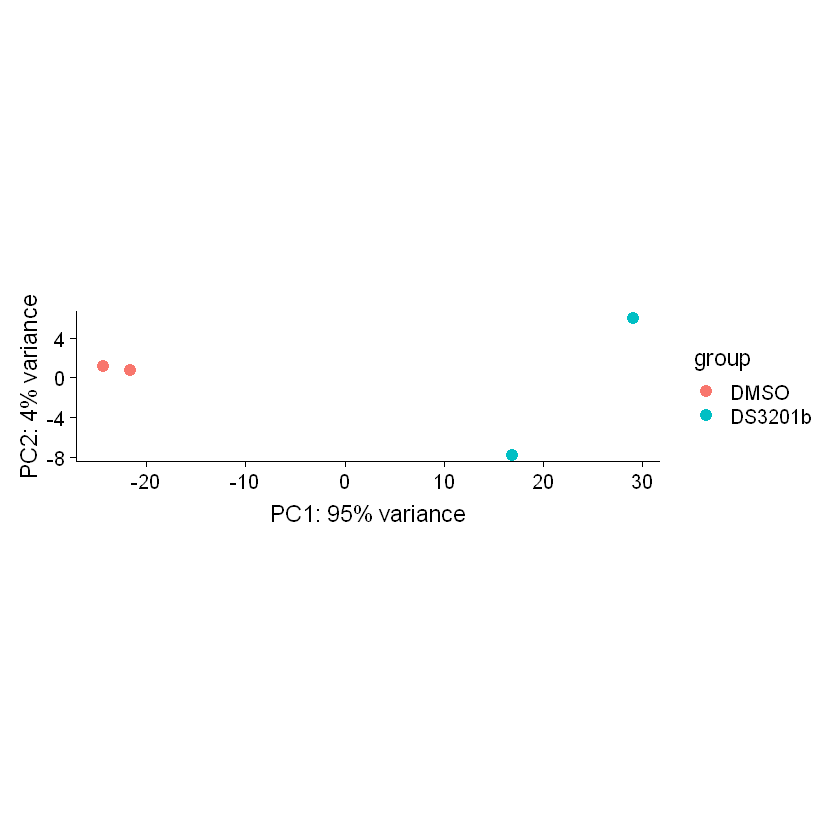

In [92]:
plotPCA(rld_0v1, intgroup="Treatment")

#### Differentially expressed genes

In [93]:
res_0v1 <- results(dds_0v1)
res_0v1 <- res[order(res_0v1$padj),]
summary(res_0v1)


out of 15395 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2751, 18%
LFC < 0 (down)     : 2655, 17%
outliers [1]       : 0, 0%
low counts [2]     : 2090, 14%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



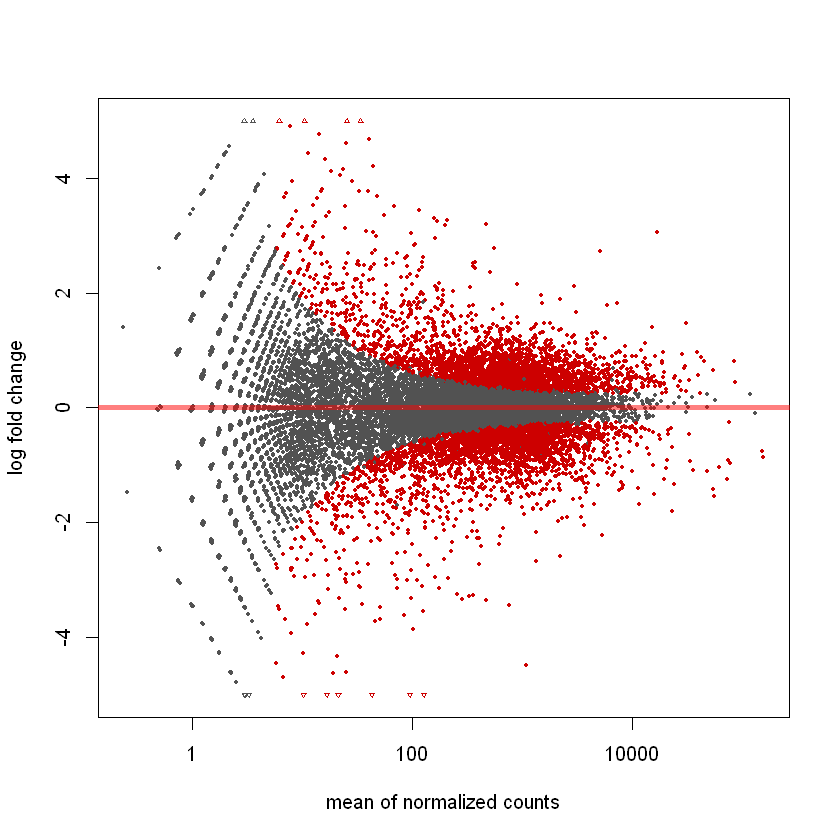

In [94]:
plotMA(res_0v1, ylim=c(-5,5))

#### Export Data

In [95]:
# Export normalized matrix
write.csv(n_data_0v1, file = "results/0v1_normalized.csv")
# Export DEG matrix
write.csv(res_0v1, file = "results/DEG_0v1.csv")

#### B. DS0 vs DS30

In [96]:
# Subset the 0v30
data_0v30 <- data_merged[,c("E","F","I","J")]
pdata_0v30 <- pdata[c("E","F","I","J"),]

In [98]:
# DESeq analaysis
dds_0v30 <- DESeqDataSetFromMatrix(countData = data_0v30, colData = pdata_0v30, design = ~ Treatment)
dds_0v30 <- DESeq(dds_0v30)
# Normalize the data by rlog method for other analysis
rld_0v30 <- rlog(dds_0v30, blind=FALSE)
# Extract the normalised data from the deseq file
n_data_0v30 <- data.frame(assay(rld_0v30))
head(n_data_0v30)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


,E,F,I,J
,9.695640,9.754992,9.727157,9.540644
A1BG-AS1,3.555583,3.578694,3.639790,3.581692
AAAS,9.161955,9.292984,9.264171,9.286327
AACS,8.266674,8.265109,8.671123,8.653785
AACSP1,1.303508,1.312139,1.330395,1.323491
AAGAB,9.376029,9.237196,9.347681,9.334009


#### Vizulaize expression profile before and after normalization

SHA-1 hash of file is ea705fcd7367ec2f0f16b7660c0ae5b75421a27c
No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 1245 rows containing non-finite values (stat_boxplot)."

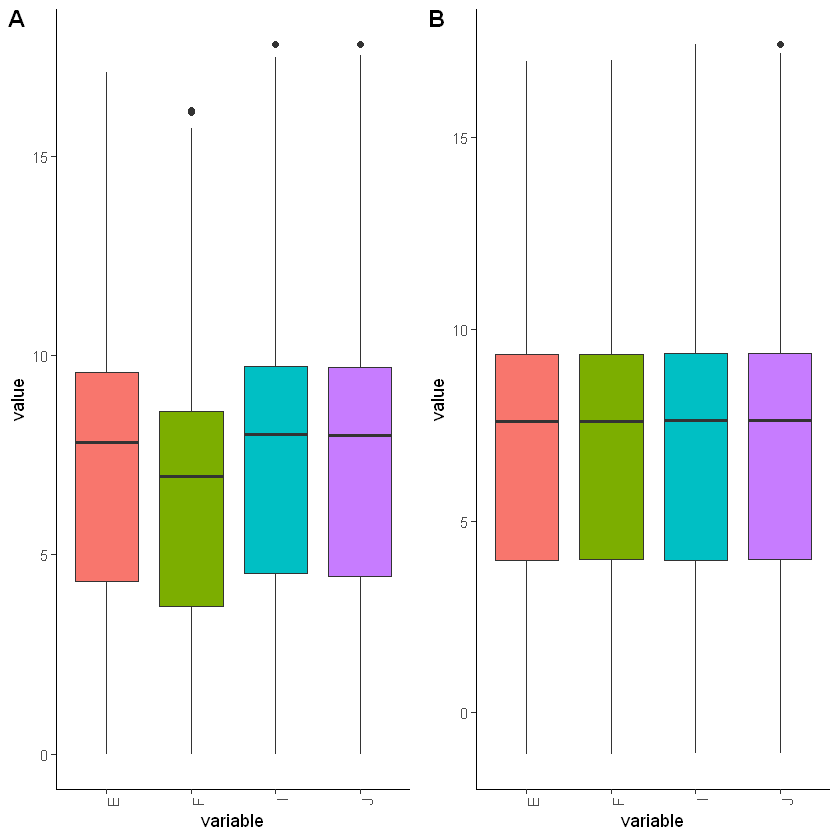

In [99]:
source_url("https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/r_scripts/plot_before_after_normalization.R")
plotba (data_0v30,n_data_0v30)

#### Plot PCA

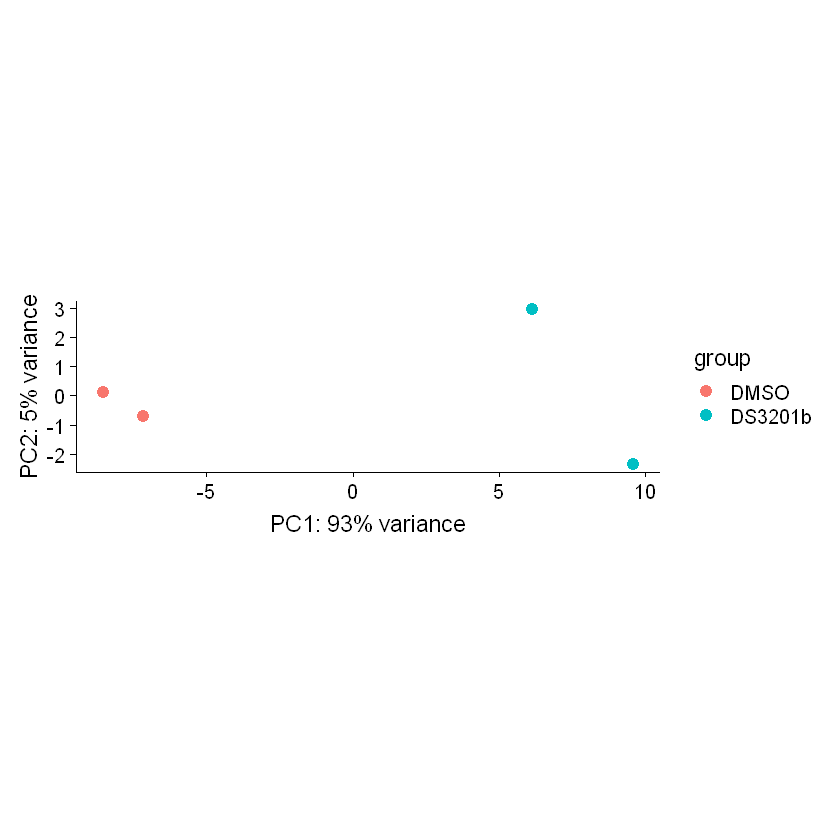

In [100]:
plotPCA(rld_0v30, intgroup="Treatment")

#### Differentially expressed genes

In [101]:
res_0v30 <- results(dds_0v30)
res_0v30 <- res[order(res_0v30$padj),]
summary(res_0v30)


out of 15395 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2751, 18%
LFC < 0 (down)     : 2655, 17%
outliers [1]       : 0, 0%
low counts [2]     : 2090, 14%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



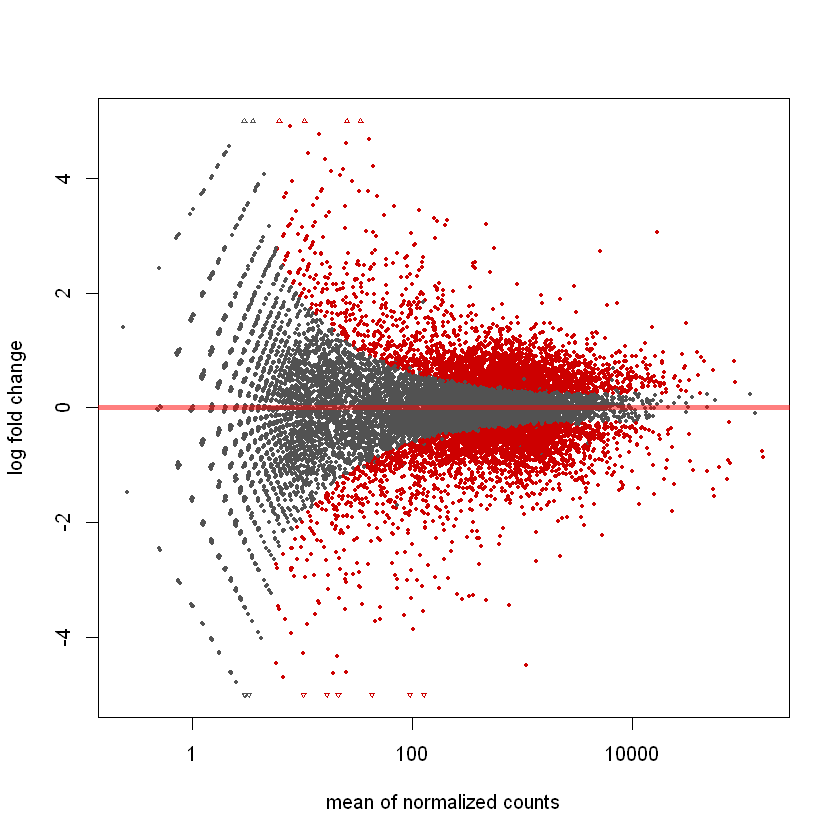

In [102]:
plotMA(res_0v30, ylim=c(-5,5))

#### Export Data

In [103]:
# Export normalized matrix
write.csv(n_data_0v30, file = "results/0v30_normalized.csv")
# Export DEG matrix
write.csv(res_0v30, file = "results/DEG_0v30.csv")